In [2]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

## Load masks

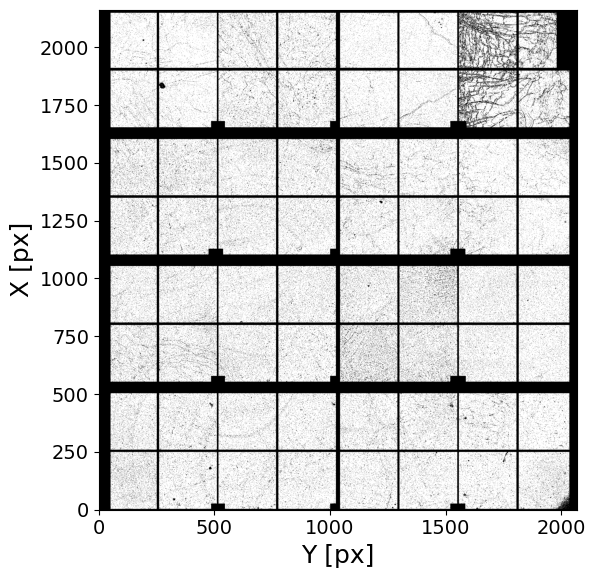

In [3]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Kossel mask gen: delcoup=10, T=12h (Ta2O5_2.5um, 2, 4)

In [4]:
#######################################
sample_name = 'Ta2O5_2.5um'
Ndataset = 2
Nscan = 4
load_mask = None #e4m_mask*e4m_htmask
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

##########################################################
Nfi, Nff = None, int(2e5)
##########################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=1, )
#e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 2 86000501
Ei = 21.669991317784486
itime = 0.0011
T =  15.707186611111112 h
theta = 10.0
Qc = 1.91
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/41 l

### Kossel mask generation

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  373437 pixels (of 4471016 => 10.94 %)
# of pixels below Ith_low treshold ->  122673 pixels (of 4471016 => 3.6 %)
################################################################################



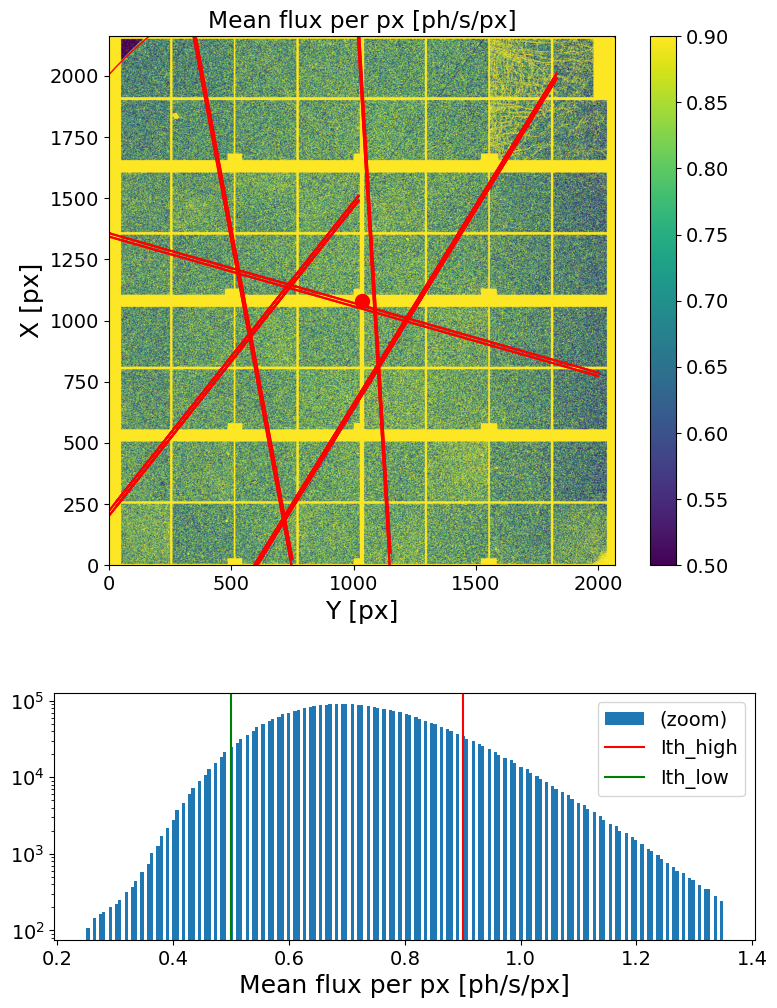

In [14]:
mask_geom_line = [{'geom':'Line', 'x0':250, 'y0':30,  'x1':1500, 'y1':1020, 'linewidth':20}, 
                  {'geom':'Line', 'x0':0,   'y0':600, 'x1':2000, 'y1':1830, 'linewidth':20}, 
                  {'geom':'Line', 'x0':0,   'y0':750, 'x1':2000, 'y1':380, 'linewidth':50}, 
                  {'geom':'Line', 'x0':780, 'y0':2000, 'x1':1350, 'y1':0, 'linewidth':15}, 
                  {'geom':'Line', 'x0':0, 'y0':1150, 'x1':1500, 'y1':1060, 'linewidth':100}]
mask_geom_circle = [{'geom':'Circle', 'Cx':Nx//2-80, 'Cy':Ny//2+80, 'r':1500, 'inside':True}]
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.5, Ith_high=.9, Nfi=None, Nff=int(1e5), mask=e4m_mask*e4m_htmask, mask_geom=mask_geom_circle+mask_geom_line)

#################################################
Masked area =  97.08205025434935 %
#################################################



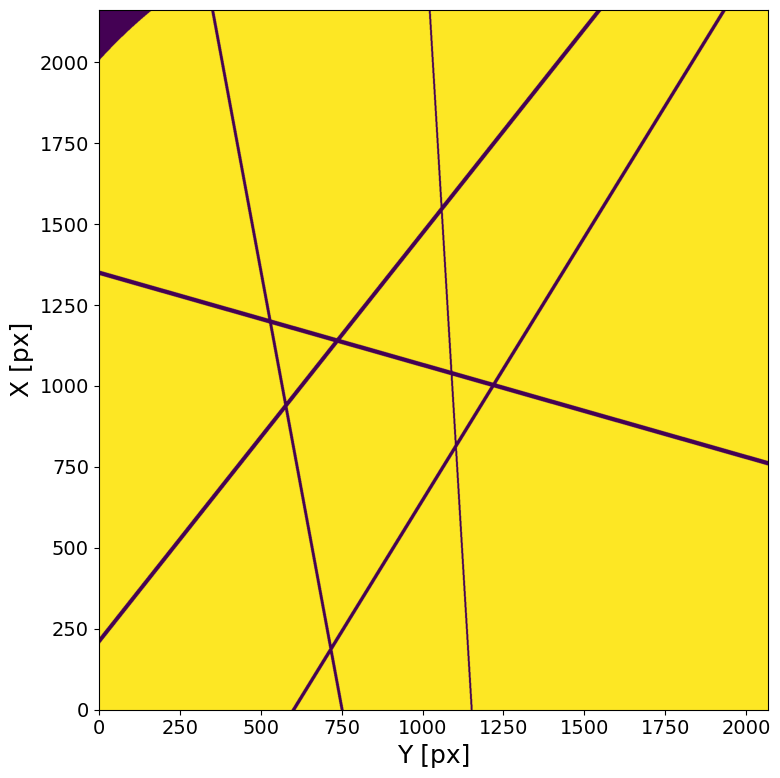

In [15]:
Kossel_mask = XPCS.gen_mask(mask_geom=mask_geom_line+mask_geom_circle)

In [16]:
np.save(MASKS_folder  + 'Kossel_mask_Ta2O5_2.5um_0002_0004.npy', Kossel_mask)

### Kossel mask test

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  360677 pixels (of 4471016 => 10.87 %)
# of pixels below Ith_low treshold ->  117518 pixels (of 4471016 => 3.54 %)
################################################################################



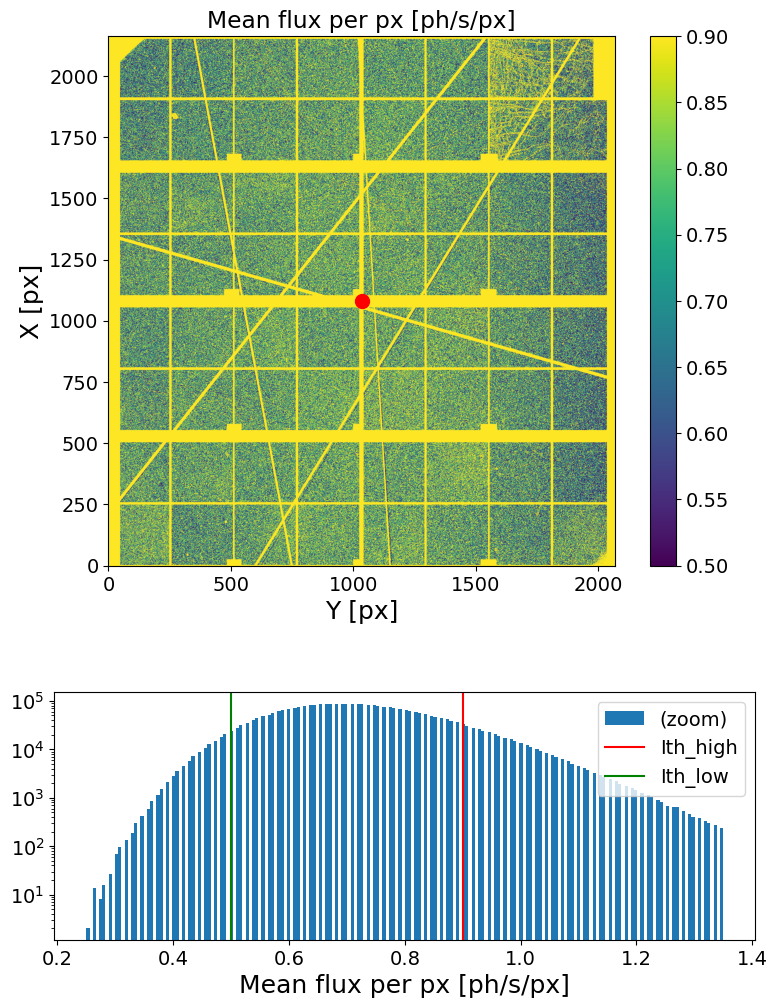

In [17]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.5, Ith_high=.9, Nfi=int(1e5), Nff=int(2e5), mask=e4m_mask*e4m_htmask*Kossel_mask)

## Kossel mask gen: delcoup=1.7, T=12h (Ta2O5_2.5um_asdep, 2, 1)

In [18]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 2
Nscan = 1
load_mask = None #e4m_mask*e4m_htmask
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

##########################################################
Nfi, Nff = None, int(2e5)
##########################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=1, )
#e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  1.798072527777778 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/41 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_0001

### Kossel mask generation

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  16635 pixels (of 4471016 => 0.49 %)
# of pixels below Ith_low treshold ->  252223 pixels (of 4471016 => 7.39 %)
################################################################################



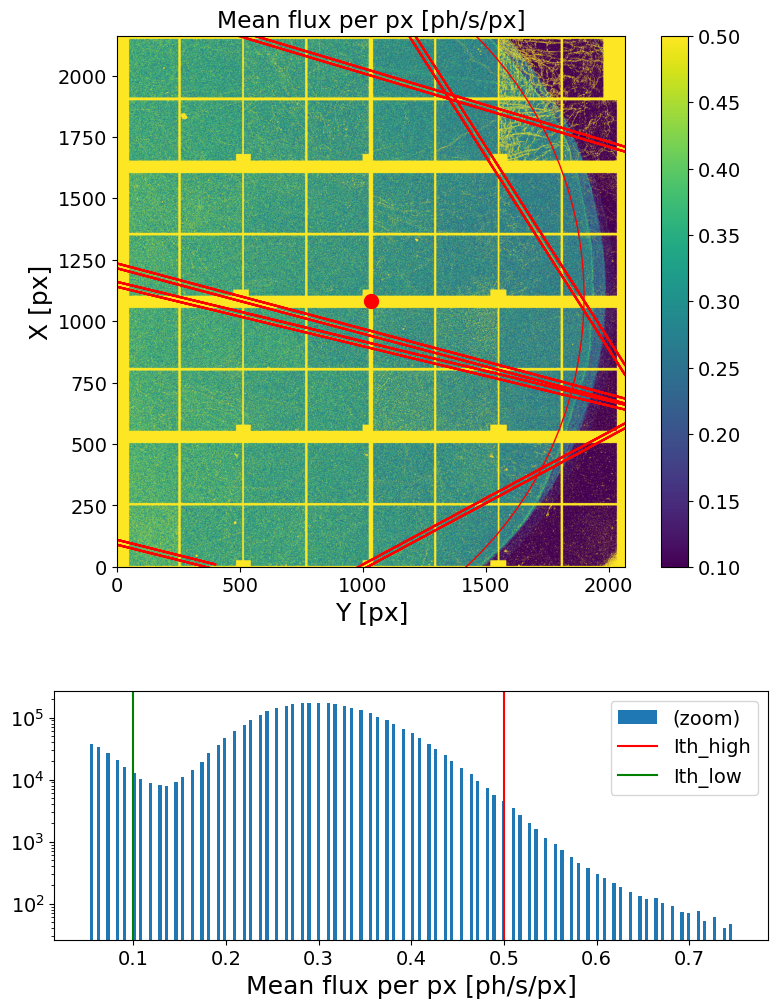

In [20]:
mask_geom_line = [{'geom':'Line', 'x0':Nx, 'y0':525,  'x1':1700, 'y1':Ny, 'linewidth':20},
                  {'geom':'Line', 'x0':Nx, 'y0':1200,  'x1':800, 'y1':Ny, 'linewidth':40},
                  {'geom':'Line', 'x0':0, 'y0':1000,  'x1':575, 'y1':Ny, 'linewidth':20},
                  {'geom':'Line', 'x0':100, 'y0':0,  'x1':0, 'y1':400, 'linewidth':20},
                  {'geom':'Line', 'x0':1150, 'y0':0,  'x1':650, 'y1':Ny, 'linewidth':20},
                  {'geom':'Line', 'x0':1225, 'y0':0,  'x1':675, 'y1':Ny, 'linewidth':20},
                  ]
                 

mask_geom_circle = [{'geom' : 'Circle', 'Cx': 1100, 'Cy':400, 'r':1500, 'inside': True}]


XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.1, Ith_high=.5, Nfi=None, Nff=int(1e5), mask=e4m_mask*e4m_htmask, mask_geom=mask_geom_line+mask_geom_circle)

#################################################
Masked area =  81.69673291260868 %
#################################################



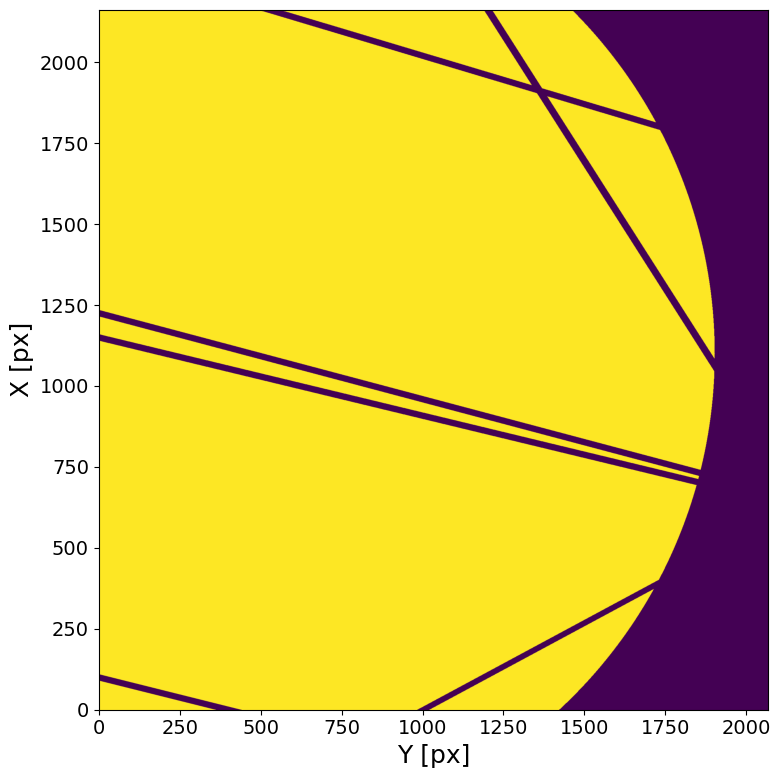

In [21]:
Kossel_mask = XPCS.gen_mask(mask_geom=mask_geom_circle+mask_geom_line)

In [22]:
np.save(MASKS_folder  + 'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy', Kossel_mask)

### Kossel mask test

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  13680 pixels (of 4471016 => 0.48 %)
# of pixels below Ith_low treshold ->  62 pixels (of 4471016 => 0.0 %)
################################################################################



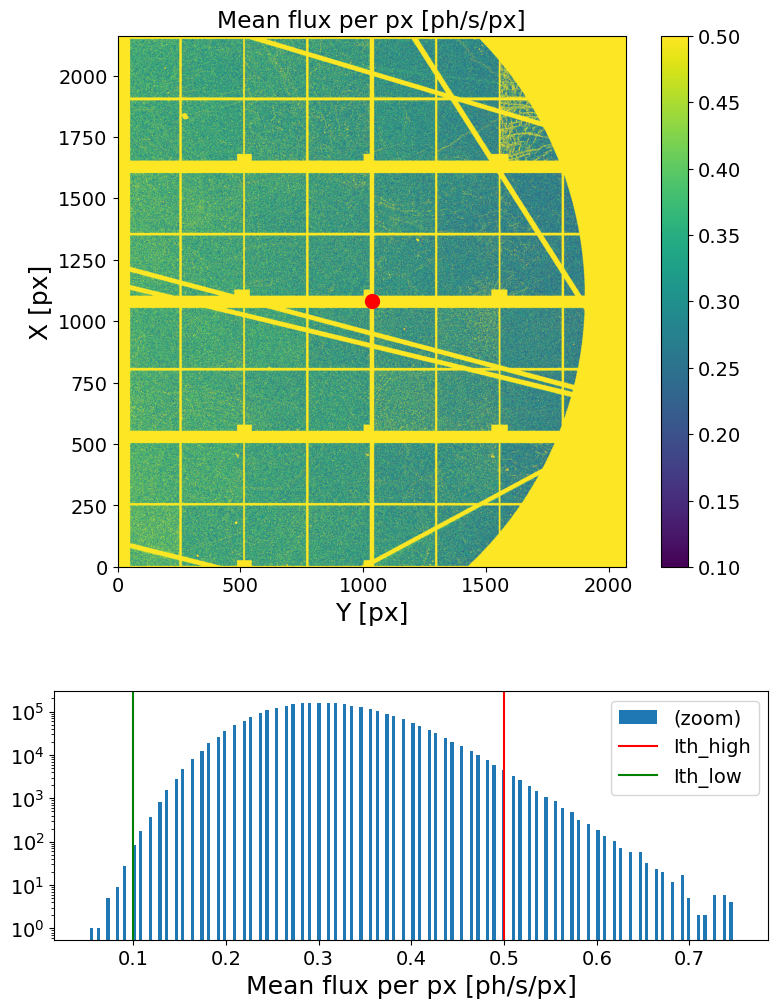

In [23]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.1, Ith_high=.5, Nfi=int(1e5), Nff=int(2e5), mask=e4m_mask*e4m_htmask*Kossel_mask)